# Plots for Figure 4

In [1]:
%matplotlib inline
import numpy as np
import os
from datavyz import ge

In [2]:
%run bash/load_batch_simulations.py
RESP_PASSIVE = build_full_dataset(key='passive',
                                  folder = os.path.join('data', 'bg-modul'),
                                  filename_only=True)

In [3]:
# plotting function in script:
%run plots/plot_single_sim_bg_data.py

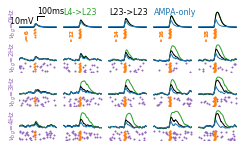

In [14]:
props = {'NSTIMs':[6,12,14,16,18],
         'alphaZn':[0., 0.45],
         'syn_location':1, 'stimseeds':[1], 'seeds':[0],
         'with_ampa_only':True,
         'LWS':[1,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L4->L23', 'L23->L23', 'AMPA-only'],
         'bar_scale_args':dict(Xbar = 100, Xbar_label='100ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(1.9,.075), 'view':[-200,300], 'shift':100, 'VLIM':[-76,-30]}
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,2,3,4], **props)
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'B.svg'))

In [75]:
%run bash/load_batch_simulations.py
RESP_PASSIVE_PER_STIM = build_full_dataset_per_stim(key='passive',
                                                    with_Vm_trace=True,
                                                    folder = os.path.join('data', 'bg-modul'),
                                                    filename_only=True)

<Figure size 432x288 with 0 Axes>

In [99]:
props = {'syn_location':1, 'thresholds':{'Integral':1.5}} # 'VLIM':[-76,0], 
AMPA = get_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0., **props)

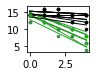

In [101]:
SLOPES_PASSIVE = {'free':[], 'chelated':[]}
fig, ax= ge.figure()
for i in np.unique(RESP_PASSIVE_PER_STIM['syn_location']):
    props = {'syn_location':i, 'thresholds':{'Integral':1.5}}
    FREE=get_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
    CHELATED=get_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)
    for C, color, key in zip([FREE, CHELATED],
                             ['k', ge.green], ['free', 'chelated']):
        x = [C[i]['bg_level'] for i in range(len(C))]
        y = [C[i]['Integral-threshold'] for i in range(len(C))]
        lin = np.polyfit(x, y, 1)
        SLOPES_PASSIVE[key].append(-lin[0])
        ge.scatter(x, y, color=color, ax=ax, no_set=True)
        ge.plot(x, np.polyval(lin, x), color=color, ax=ax, no_set=True)

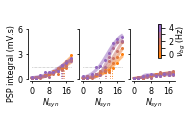

In [94]:
def show_response_bg_dep(FREE, CHELATED, AMPA,
                         ge=ge, method='Integral', ylabel='PSP integral (mV.s)       ',
                         BG_levels=None, crossing=None,
                         xlim=None, ylim=None, yscale='lin'):
    
    if BG_levels is None:
        BG_levels = [R['bg_level'] for R in FREE]
        
    CS = [CHELATED, FREE, AMPA]
    fig, AX = ge.figure(axes=(3,1), figsize=(.82,1.1), wspace=0.3, right=1.5)
    
    for ibg, bg in enumerate(BG_levels):
        if method[:5]=='delta':
            AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method[5:]]-FREE[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method[5:]]-CHELATED[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        else:
            for C, ax in zip(CS, AX):
                # data
                try:
                    ge.scatter(C[ibg]['nstims'], C[ibg][method], 
                        ax=ax, color=cmap(ibg/(len(BG_levels)-1)), no_set=True, lw=0, ms=2)
                    # fit
                    x, coefs = np.linspace(C[ibg]['nstims'][0], C[ibg]['nstims'][-1], 100), C[ibg][method+'-coeffs']
                    y = coefs[0]*sigmoid_func(x, coefs[1], coefs[2])
                    ge.plot(x, y, ax=ax, color=cmap(ibg/(len(BG_levels)-1)), no_set=True, lw=3, alpha=0.5)
                except IndexError:
                    pass
                # ADDING THE c50 position:
                if crossing is not None:
                    try:
                        ix0 = min(np.argwhere(y>crossing).flatten())
                        ax.plot(np.ones(2)*x[ix0], [0,crossing], ':', lw=1, color=cmap(ibg/(len(BG_levels)-1)))
                    except ValueError:
                        pass
    if crossing is not None:
        for ax in AX[:2]:
            ax.plot([x[0], x[-1]], crossing*np.ones(2), ':', lw=0.5, color=ge.dimgrey)
        
    props = dict(ylim=ylim, xlim=xlim, yscale=yscale, xlabel='$N_{syn}$', 
                 xticks=[0,8,16], yticks=[0,3,6], tck_length=2, tck_outward=2)
    ge.set_plot(AX[0], ylabel=ylabel, yticks_labels=['0','3','6'], **props)
    ge.set_plot(AX[1], yticks_labels=['' for i in range(3)], **props)
    ge.set_plot(AX[2], yticks_labels=['' for i in range(3)], **props)
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.84,.55,.02, .3]),
                  ticks_labels=['0', ' ', ' ',  '2', ' ' , '4'],
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig #, fig2

fig1 = show_response_bg_dep(CHELATED, FREE, AMPA, ge=ge,
                           ylim=[0, 6],# xlim=[0,18],
                           crossing=props['thresholds']['Integral'])
fig1.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'D.svg'))

In [5]:
%run bash/load_batch_simulations.py
RESP_ACTIVE = build_full_dataset(key='active',
                                 folder = os.path.join('data', 'bg-modul'),
                       
                                 filename_only=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

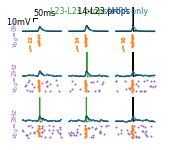

In [12]:
%run plots/plot_single_sim_bg_data.py
props = {'NSTIMs':[12,14,16],
         'alphaZn':[0., 0.45],
         'syn_location':1, 'stimseeds':[0], 'seeds':[0,0,0,0,1],
         'with_ampa_only':True,
         'LWS':[1,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar=50, Xbar_label='50ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(1.5,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-85,-0]}

fig = plot_single_sim_bg_data(RESP_ACTIVE, ge,
                              bg_levels=[0.,2,3], **props)
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'C.svg'))

In [163]:
%run bash/load_batch_simulations.py
RESP_ACTIVE_PER_STIM = build_full_dataset_per_stim(key='active',
                                    with_Vm_trace=True,
                                    folder = os.path.join('data', 'bg-modul'),
                                    filename_only=True)

<Figure size 432x288 with 0 Axes>

In [164]:
props = {'syn_location':5, 'thresholds':{'Proba':0.5}} # 'VLIM':[-76,0], 

AMPA = get_trial_average_responses(RESP_ACTIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0., **props)

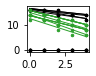

In [228]:
SLOPES_ACTIVE = {'free':[], 'chelated':[]}
GAIN_ACTIVE = {'free':[], 'chelated':[], 'ampa':[]}
fig, ax= ge.figure()
for k, i in enumerate(np.unique(RESP_ACTIVE_PER_STIM['syn_location'])):
    props = {'syn_location':i, 'thresholds':{'Proba':0.5}}
    FREE=get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0.45, **props)
    CHELATED=get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0., **props)
    AMPA = get_trial_average_responses(RESP_ACTIVE_PER_STIM, 'ampa-only', **props)
    for C, key in zip([FREE, CHELATED, AMPA],
                             ['free', 'chelated', 'ampa']):
        GAIN_ACTIVE[key].append(np.mean([np.mean(np.array(c['Proba'])[np.isfinite(c['Proba'])])/np.mean(np.array(c['nstims'])[np.isfinite(c['Proba'])]) if len(np.isfinite(c['Proba']))>0 else 0 for c in C]))
    for C, color, key in zip([FREE, CHELATED],
                             ['k', ge.green], ['free', 'chelated']):
        x = [C[i]['bg_level'] for i in range(len(C))]
        y = [C[i]['Proba-threshold'] for i in range(len(C))]
        lin = np.polyfit(x, y, 1)
        SLOPES_ACTIVE[key].append(-lin[0])
        ge.scatter(x, y, color=color, ax=ax, no_set=True)
        ge.plot(x, np.polyval(lin, x), color=color, ax=ax, no_set=True)

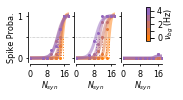

In [97]:
def show_response_bg_dep(FREE, CHELATED, AMPA,
                         ge=ge, method='Proba', ylabel='Spike Proba.',
                         BG_levels=None, crossing=None,
                         xlim=None, ylim=None, yscale='lin'):
    
    if BG_levels is None:
        BG_levels = [R['bg_level'] for R in FREE]
        
    CS = [CHELATED, FREE, AMPA]
    fig, AX = ge.figure(axes=(3,1), figsize=(.78,1.1), wspace=0.3, right=1.5)
    
    for ibg, bg in enumerate(BG_levels):
        if method[:5]=='delta':
            AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method[5:]]-FREE[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method[5:]]-CHELATED[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        else:
            for C, ax in zip(CS, AX):
                # data
                try:
                    ge.scatter(C[ibg]['nstims'], C[ibg][method], 
                        ax=ax, color=cmap(ibg/(len(BG_levels)-1)), no_set=True, lw=0, ms=2)
                    # fit
                    x, coefs = np.linspace(C[ibg]['nstims'][0], C[ibg]['nstims'][-1], 100), C[ibg][method+'-coeffs']
                    y = coefs[0]*sigmoid_func(x, coefs[1], coefs[2])
                    ge.plot(x, y, ax=ax, color=cmap(ibg/(len(BG_levels)-1)), no_set=True, lw=3, alpha=0.5)
                except IndexError:
                    pass
                # ADDING THE c50 position:
                if crossing is not None:
                    try:
                        ix0 = min(np.argwhere(y>crossing).flatten())
                        ax.plot(np.ones(2)*x[ix0], [0,crossing], ':', lw=1, color=cmap(ibg/(len(BG_levels)-1)))
                    except ValueError:
                        pass
    if crossing is not None:
        for ax in AX[:2]:
            ax.plot([x[0], x[-1]], crossing*np.ones(2), ':', lw=0.5, color=ge.dimgrey)
        
    props = dict(ylim=ylim, xlim=xlim, yscale=yscale, xlabel='$N_{syn}$', 
                 xticks=[0,8,16], yticks=[0,0.5,1.], tck_length=2, tck_outward=2)
    ge.set_plot(AX[0], ylabel=ylabel, yticks_labels=['0','','1'], **props)
    ge.set_plot(AX[1], yticks_labels=['' for i in range(3)], **props)
    ge.set_plot(AX[2], yticks_labels=['' for i in range(3)], **props)
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.84,.55,.02, .3]),
                  ticks_labels=['0', ' ', ' ',  '2', ' ' , '4'],
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig #, fig2

fig1 = show_response_bg_dep(CHELATED, FREE, AMPA, method='Proba', ge=ge,
                           ylim=[-0.1,1.1], xlim=[0,18],
                           crossing=props['thresholds']['Proba'])
fig1.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'E.svg'))

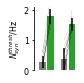

In [142]:
fig, ax = ge.figure(figsize=(.8,1.4))
ax.bar([0], [np.mean(SLOPES_PASSIVE['free'])], yerr=[np.std(SLOPES_PASSIVE['free'])], color=ge.grey)
ax.bar([1], [np.mean(SLOPES_PASSIVE['chelated'])], yerr=[np.std(SLOPES_PASSIVE['chelated'])], color=ge.green)
for x1, x2 in zip(SLOPES_PASSIVE['free'], SLOPES_PASSIVE['chelated']):
    ax.plot([0,1], [x1,x2], 'k-', lw=0.1)
ax.bar([2.7], [np.mean(SLOPES_ACTIVE['free'])], yerr=[np.std(SLOPES_ACTIVE['free'])], color=ge.grey)
ax.bar([3.7], [np.mean(SLOPES_ACTIVE['chelated'])], yerr=[np.std(SLOPES_ACTIVE['chelated'])], color=ge.green)
for x1, x2 in zip(SLOPES_ACTIVE['free'], SLOPES_ACTIVE['chelated']):
    ax.plot([2.7,3.7], [x1,x2], 'k-', lw=0.1)
ge.set_plot(ax, ['left'], yticks=[0,1,2], tck_length=2, ylim=[0,2.1],
            ylabel='$N_{syn}^{thresh}$/Hz')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'F.svg'))

In [143]:
from scipy.stats import wilcoxon
print('Passive ->', wilcoxon(SLOPES_PASSIVE['free'], SLOPES_PASSIVE['chelated']))
print('Active ->', wilcoxon(SLOPES_ACTIVE['free'], SLOPES_ACTIVE['chelated']))

Passive -> WilcoxonResult(statistic=0.0, pvalue=0.004808563078561355)
Active -> WilcoxonResult(statistic=0.0, pvalue=0.005005074402905223)


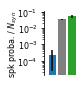

In [230]:
fig, ax = ge.figure(figsize=(.7,1.4))
for i, key, color in zip(range(3), ['ampa', 'free', 'chelated'], [ge.blue, ge.grey, ge.green]):
    cond = np.isfinite(GAIN_ACTIVE[key])
    my, sy = np.array(GAIN_ACTIVE[key])[cond].mean(), np.array(GAIN_ACTIVE[key])[cond].std()
    ax.bar([i], [my], yerr=[sy], color=color)
ge.set_plot(ax, ['left'], yscale='log', ylabel='spk proba. / $N_{syn}$ ', 
            tck_outward=3, tck_length=3, ylabelpad=-3)
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'F.svg'))

## Decoding

In [ ]:
ge.set_plot(ax, ['left'], yticks=[0,1,2],
            ylabel='decoding\n accuracy (%)')